In [58]:
!nvidia-smi

Thu Apr 15 15:29:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    921MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd


In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('./drive/MyDrive/bitTrader2/train_x_df.csv')
train_y_2 = pd.read_csv('./drive/MyDrive/bitTrader2/train_y_df.csv') 
test_x_2 = pd.read_csv('./drive/MyDrive/bitTrader2/test_x_df.csv') 
submission = pd.read_csv('./drive/MyDrive/bitTrader2/sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [15]:
x_train_close = x_train[:,:,4] 
y_train_close = y_train[:,:,4] 
x_test_close = x_test[:,:,4] 

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1) 
close_prices.shape


(7661, 1500)

In [16]:
K = 120 
N = 60 
seq_len = 1500 
features = 1
X = [] 
Y = [] 

for j in tqdm(range(close_prices.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X.append(close_prices[j, i:i+N]) 
        Y.append(close_prices[j, i+N+K]) # get close prices as target
        i += 1   
        
        
X = np.asarray(X) 
Y = np.asarray(Y)

X.shape, Y.shape 


100%|██████████| 7661/7661 [00:09<00:00, 794.71it/s]


((10112520, 60), (10112520,))

In [17]:
X = X.reshape((-1,N,features)) 
X.shape

(10112520, 60, 1)

In [18]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [19]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 2, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    
def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    time_embedding = Time2Vector(N)
    inputs = Input((N, features))
    bn = BatchNormalization()(inputs) 
    x = time_embedding(bn) 
    x = Concatenate()([bn, x]) 
    x = Conv1D(node*2, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation)
        
    x = GlobalMaxPooling1D()(x)
    x = Dropout(drop_rate)(x)
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=inputs,outputs=x) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [ ]:
model = build_transformer()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 60, 2)        240         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 3)        0           batch_normalization[0][0]        
                                                                 time2_vector[0][0]           

In [ ]:
model_path = './drive/MyDrive/bitTrader2/Transformer_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                   Y, 
                   batch_size = 128, 
                   epochs = 25, 
                   callbacks = [learning_rate_reduction, checkpoint], 
                   validation_split = 0.1)


Epoch 1/25
74336/74336 [==============================] - 1139s 15ms/step - loss: 2.0974 - mae: 0.0210 - mse: 0.0044 - mape: 2.0974 - val_loss: 0.7929 - val_mae: 0.0080 - val_mse: 3.2719e-04 - val_mape: 0.7929

Epoch 00001: val_loss improved from inf to 0.79291, saving model to ./drive/MyDrive/bitTrader2/Transformer_N_plus_60_epoch_001_val_0.793.h5
Epoch 2/25
74336/74336 [==============================] - 1134s 15ms/step - loss: 0.8938 - mae: 0.0089 - mse: 2.1438e-04 - mape: 0.8938 - val_loss: 0.8030 - val_mae: 0.0081 - val_mse: 3.2599e-04 - val_mape: 0.8030

Epoch 00002: val_loss did not improve from 0.79291
Epoch 3/25
74336/74336 [==============================] - 1131s 15ms/step - loss: 0.8918 - mae: 0.0089 - mse: 2.1431e-04 - mape: 0.8918 - val_loss: 0.7879 - val_mae: 0.0079 - val_mse: 3.3074e-04 - val_mape: 0.7879

Epoch 00003: val_loss improved from 0.79291 to 0.78795, saving model to ./drive/MyDrive/bitTrader2/Transformer_N_plus_60_epoch_003_val_0.788.h5
Epoch 4/25
74336/74336 [

In [20]:
best_model1 = load_model('./drive/MyDrive/bitTrader2/Transformer_N_plus_60_epoch_009_val_0.761.h5', custom_objects = {'Time2Vector':Time2Vector}) 
best_model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 1)        4           input_1[0][0]                    
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 60, 2)        240         batch_normalization[0][0]        
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 3)        0           batch_normalization[0][0]        
                                                                 time2_vector_3[0][0]         

In [21]:
best_model2 = load_model('./drive/MyDrive/bitTrader2/Transformer_epoch_019_val_0.986.h5', custom_objects = {'Time2Vector':Time2Vector}) 
best_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 1)        4           input_2[0][0]                    
__________________________________________________________________________________________________
time2_vector_4 (Time2Vector)    (None, 60, 2)        240         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 60, 3)        0           batch_normalization_1[0][0]      
                                                                 time2_vector_4[0][0]       

In [44]:
X_test = [] 
for i in tqdm(range(x_test.shape[0])): 
  for j in range(seq_len-N-K-120, seq_len-N-K): 
    X_test.append(x_test_close[i, j:j+N]) 

X_test = np.asarray(X_test)
X_test = X_test.reshape((-1,N,1)) 
X_test.shape

100%|██████████| 535/535 [00:00<00:00, 17355.83it/s]


(64200, 60, 1)

In [45]:
predicted1 = best_model1.predict(X_test) 
predicted1 = predicted1.reshape((-1,120)) 
predicted2 = best_model2.predict(X_test) 
predicted2 = predicted2.reshape((-1,120)) 

predicted1.shape, predicted2.shape

((535, 120), (535, 120))

In [46]:
predicted1 = predicted1[:,60:] 
predicted2 = predicted2[:,60:] 

predicted1.shape, predicted2.shape

((535, 60), (535, 60))

In [47]:
## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted1.shape[0]), position = 0, leave = True):
    buy_price = x_test_close[i,-1] 
    if predicted1[i,0] > buy_price:
        diff = predicted1[i,0] - buy_price 
        predicted1[i,:] -= diff 
    elif predicted1[i,0] < buy_price:  
        diff = buy_price - predicted1[i,0] 
        predicted1[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 103570.23it/s]


In [48]:
## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted2.shape[0]), position = 0, leave = True):
    buy_price = predicted1[i,-1] 
    if predicted2[i,0] > buy_price:
        diff = predicted2[i,0] - buy_price 
        predicted2[i,:] -= diff 
    elif predicted2[i,0] < buy_price:  
        diff = buy_price - predicted2[i,0] 
        predicted2[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 133030.15it/s]


In [49]:
predicted = np.concatenate([predicted1, predicted2], axis = 1) 
predicted.shape

(535, 120)

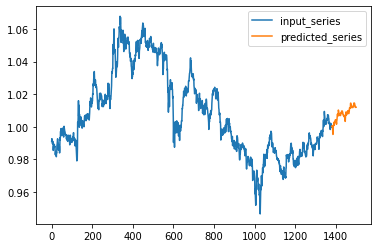

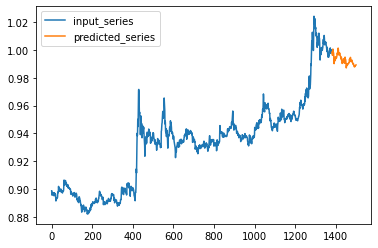

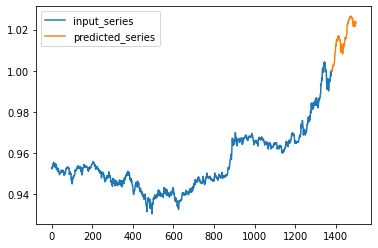

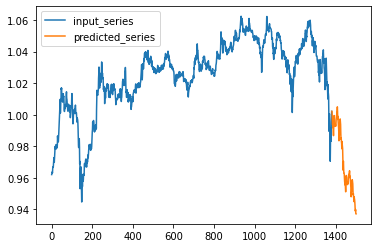

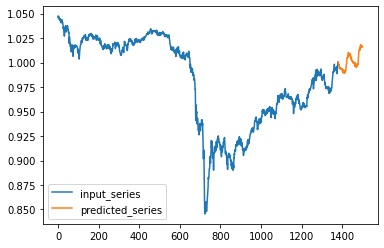

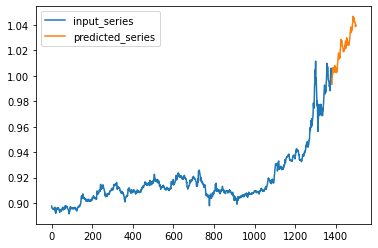

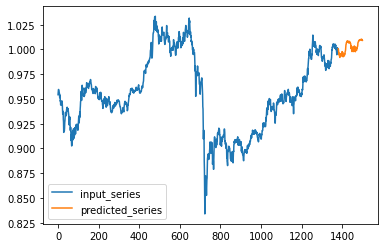

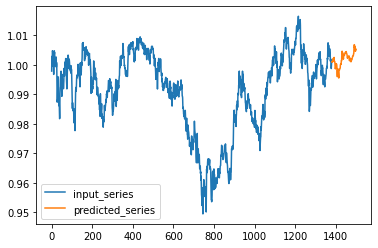

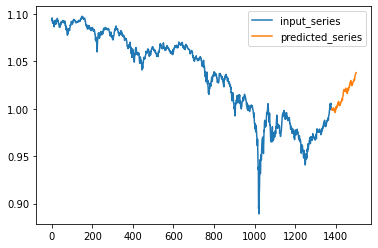

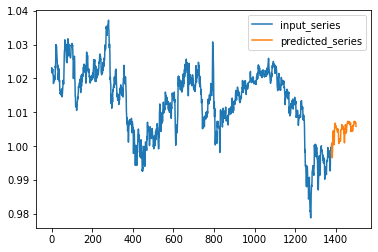

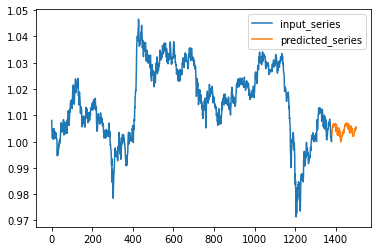

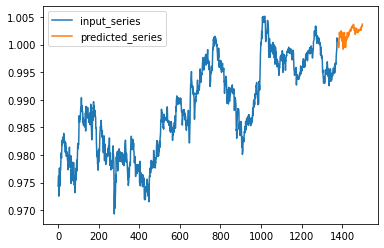

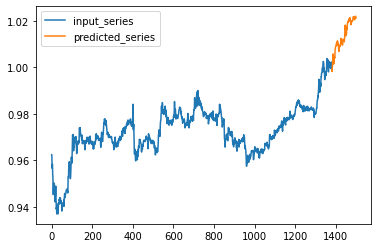

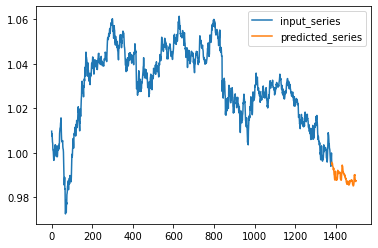

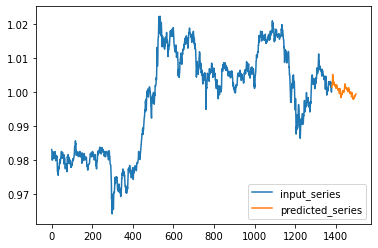

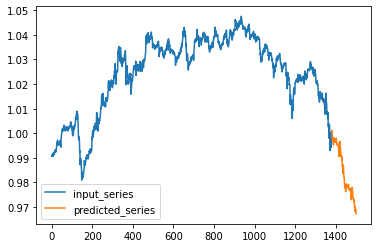

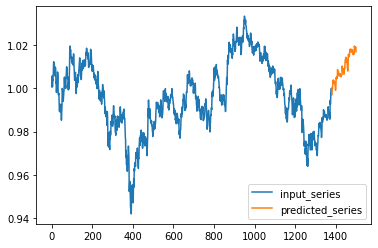

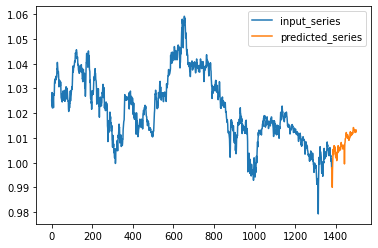

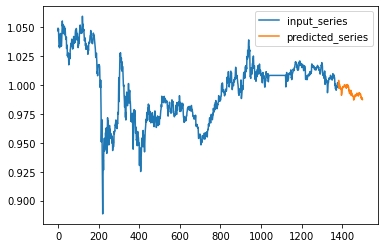

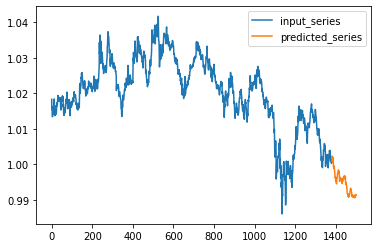

In [50]:
for i in range(20):  
  plt.plot()
  plot_predicted_series(x_test_close[i,:], predicted[i,:])
  plt.show()

In [51]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('./drive/MyDrive/bitTrader2/time2vec_transformers_60_120_mape.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4015.79it/s]


In [52]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.950000,110
1,7662,0.050000,31
2,7663,0.983333,92
3,7664,0.025000,27
4,7665,0.450000,110
...,...,...,...
530,8191,0.050000,1
531,8192,0.858333,108
532,8193,1.000000,81
533,8194,0.016667,1


In [59]:
# Create submission dataframe version 2
## proportion of positive returns 
## create submission dataframe 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    if predicted[i,0]-buy_price >= 0:
        cnt += 1 
    for j in range(1,120):  
        returns = predicted[i,j]-predicted[i,j-1] 
        if returns >= 0:  
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)


submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times 
submission


100%|██████████| 535/535 [00:00<00:00, 3469.92it/s]


,sample_id,buy_quantity,sell_time
0,7661,0.491667,110
1,7662,0.508333,31
2,7663,0.641667,92
3,7664,0.425000,27
4,7665,0.525000,110
...,...,...,...
530,8191,0.433333,1
531,8192,0.575000,108
532,8193,0.616667,81
533,8194,0.475000,1


In [62]:
submission.to_csv('./drive/MyDrive/bitTrader2/returns_time2vec_60_120.csv',index=False) 

In [53]:
pred_train1 = best_model1.predict(X[:2400,])
pred_train1 = pred_train1.reshape((-1,120))

pred_train2 = best_model2.predict(X[:2400,]) 
pred_train2 = pred_train2.reshape((-1,120)) 

pred_train1.shape, pred_train2.shape

((20, 120), (20, 120))

In [54]:
pred_train1 = pred_train1[:,60:] 
pred_train2 = pred_train2[:,60:] 
pred_train = np.concatenate([pred_train1,pred_train2],axis=1) 
pred_train.shape

(20, 120)

In [56]:
for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_close[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 20/20 [00:00<00:00, 33729.83it/s]


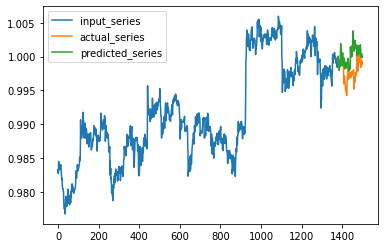

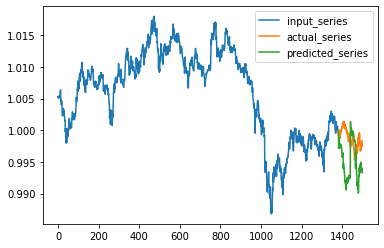

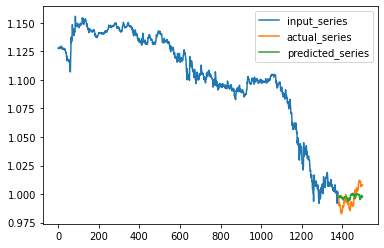

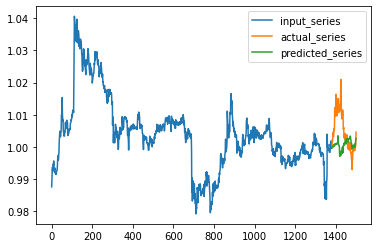

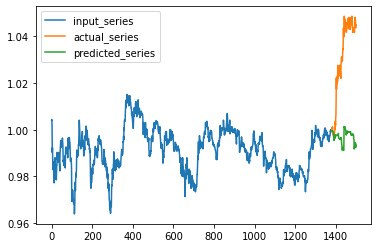

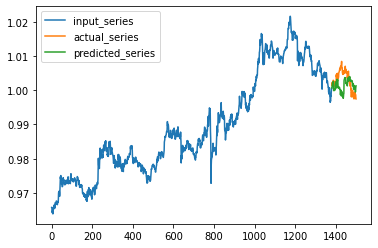

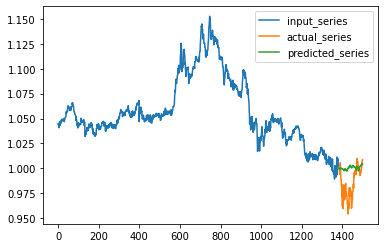

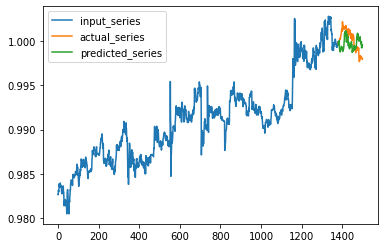

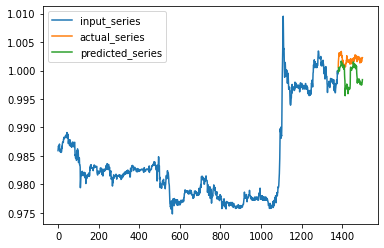

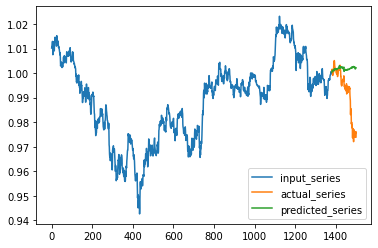

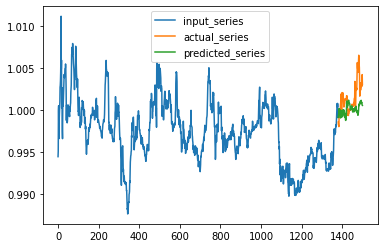

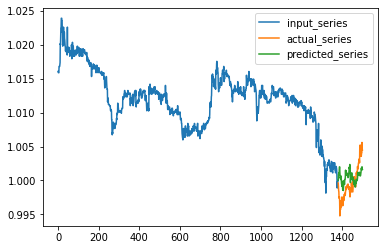

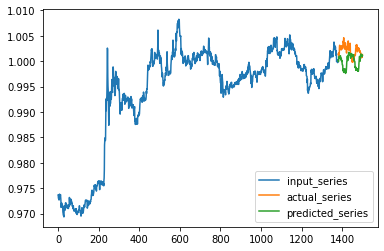

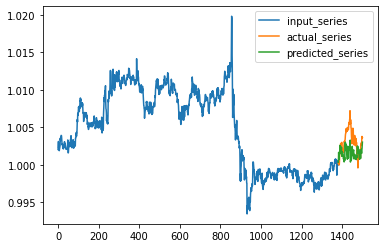

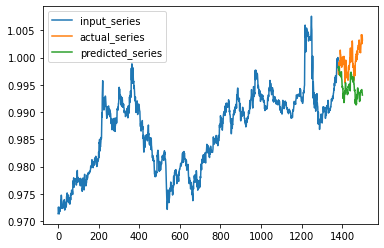

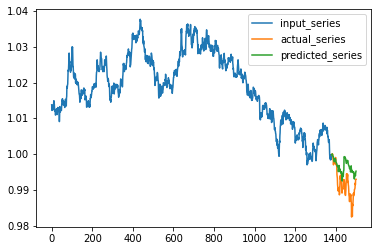

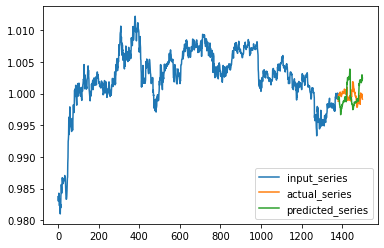

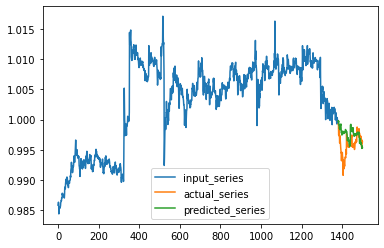

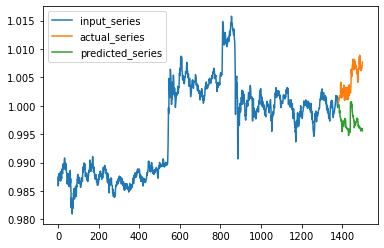

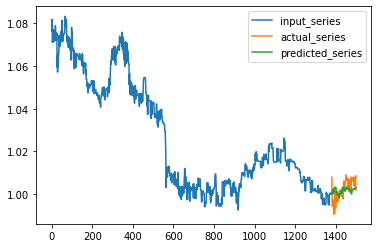

In [57]:
for i in range(20): 
  plt.plot() 
  plot_series(x_train_close[i,:], y_train_close[i,:], pred_train[i,:]) 
  plt.show()